In [7]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

tf.random.set_seed(22)

# from https://www.tensorflow.org/guide/core/optimizers_core

In [8]:
class GradientDescent(tf.Module):
    
    def __init__(self, learning_rate=1e-3):
        self.learning_rate = learning_rate
        
        self.title = f"Gradient Descent: learning_rate={self.learning_rate}"
        
    def apply_gradients(self, grads, vars):
        # vars: x1, x2, x3
        # grads: df/dx1, df/dx2, df/dx3 at x1, x2, x3
        for grad, var in zip(grads, vars):
            # xi = xi - df/dxi * lr,
            # df/dxi at xi
            var.assign_sub(grad * self.learning_rate)

The derivative of a loss function $L(x) = 2x^4 + 3^3 + 2$ is
$\frac{\mathrm{d}L}{\mathrm{d}x} = 8x^3 + 9x^2$. The derivative is
zero at $x = 0$ (local minimum of $L$) and $x = -\frac{9}{8}$ (global minimum of $L$).

In [9]:
def loss(x):
    return 2 * (x ** 4) + 3 * (x ** 3) + 2 

In [11]:
x = tf.cast(tf.linspace(-2, 2, 201), tf.float32)

def grad(f, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        result = f(x)
    return tape.gradient(result, x)

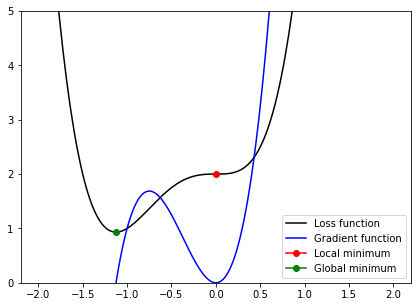

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(x, loss(x), c="k", label="Loss function")
ax.plot(x, grad(loss, x), c="blue", label="Gradient function")

ax.plot(0, loss(0), c="red", label="Local minimum", marker="o")
ax.plot(-9/8, loss(-9/8), c="green", label="Global minimum", marker="o")

ax.set_ylim([0, 5])
plt.legend()
plt.show()

In [12]:
# Tests the convergance of an optimizer.
# Convergence = updated parameters at step i are equal to parameters at i - 1.

def convergence_test(optimizer, loss_fn, grad_fn, init_val, max_iters=2000):
    
    # current optimum
    # right now, the start of the optimization
    x_current = tf.Variable(init_val)
    # x_current.numpy() deep copies the value
    param_path = [x_current.numpy()]
    converged = False
    
    msg = f"Using learning_rate={optimizer.learning_rate}. "
    
    for i in range(1, max_iters + 1):
        # gradient of the loss function at x_current
        grad_x_current = grad_fn(loss_fn, x_current)
        
        # gradient exploded
        if tf.math.is_nan(grad_x_current):
            print(msg + f"Gradient explosion at the {i}-th iteration.")
            return []
       
        # updates x_current
        optimizer.apply_gradients([grad_x_current], [x_current])
        param_path.append(x_current.numpy())
        
        if param_path[i] == param_path[i - 1]:
            print(msg + f"Converged at the {i}-th iteration.")
            return param_path
    
    print(
        msg + f"Failed to converge after {max_iters} iterations."
    )
    return param_path

In [19]:
param_paths = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
    param_paths[learning_rate] = convergence_test(
        optimizer=GradientDescent(learning_rate=learning_rate),
        loss_fn=loss,
        grad_fn=grad,
        init_val=2.0,
    )

Using learning_rate=0.001. Failed to converge after 2000 iterations.
Using learning_rate=0.01. Failed to converge after 2000 iterations.
Using learning_rate=0.1. Gradient explosion at the 6-th iteration.


In [20]:
def visualize_param_paths(param_paths, x_vals, loss_fn, title, max_iters=2000):
    # contour map of the loss function
    t_vals = tf.range(1., max_iters + 100.)
    t_grid, x_grid = tf.meshgrid(t_vals, x_vals)
    loss_grid = tf.math.log(loss_fn(x_grid))
    
    plt.subplots(1, 1, figsize=(10, 7))

    plt.pcolormesh(t_vals, x_vals, loss_grid, vmin=0, shading="nearest")
    
    colors = ["r", "w", "c"]
    for i, (learning_rate, param_path) in enumerate(param_paths.items()):
        if len(param_path) > 0:
            x_last = param_path[-1]
            iters = len(param_path)
            label = f"x*: lr={learning_rate}"
            plt.plot(t_vals[:iters], param_path, c=colors[i])
            plt.plot(iters, x_last, marker="o", c=colors[i], label=label)

    plt.xlabel("iteration")
    plt.ylabel("param value")
    plt.title(f"{title} parameter paths")
    cbar = plt.colorbar()
    cbar.set_label("loss")
    plt.legend()
    plt.show()

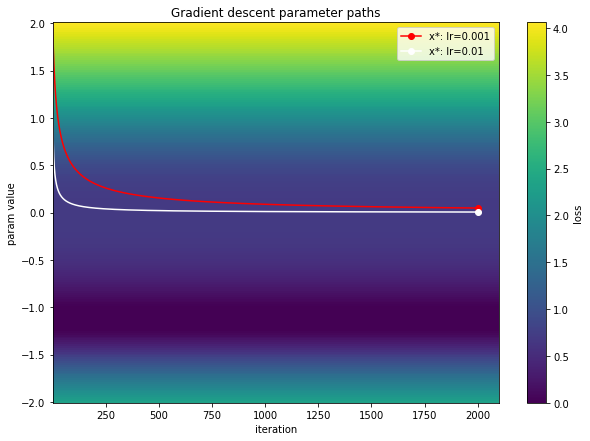

In [21]:
# Loss is a function of just one variable.
# We can visualize it along the y-axis, repeated at each iteration step

x_vals = tf.cast(tf.linspace(-2, 2, 201), tf.float32)
visualize_param_paths(param_paths, x_vals, loss, "Gradient descent", max_iters=2000)

In [1]:
# Gradients explode (lr=0.1) or the optimizer gets stuck at the saddle point (local minima)
# when the learning rate is too small.
# Solution –> gradient descent with momentum

Simple gradient descent:

$$
\Delta_x^{[t]} = r_l L'(x^{[t-1]}) \\
x^{[t]} = x^{[t - 1]} - \Delta_x^{[t]} \\
x^{[t]} = x^{[t - 1]} - r_l L'(x^{[t-1]})
$$

where $x^{[t]}$ is the optimum at the $t$-th step, $L'$ is the gradient function (derivative) of the loss $L$,
$r_l$ is the learning rate, and $\Delta_x^{[t]}$ the change of $x$ between $t$ and $t-1$.

Gradient descent with momentum:

$$
\Delta_x^{[t]} = r_l L'(x^{[t-1]}) + p\Delta_x^{[t-1]} \\
x^{[t]} = x^{[t - 1]} - \Delta_x^{[t]}
$$

where $p$ is the momentum parameter which controls the size of the effect of the previous step. The size of the update $\Delta_x^{[t]}$ depends not only on the learning rate and the gradient, but also on
the size of the previous update. This creates _momentum_ that helps the optimizer to move faster around saddle points and regions with small gradients.

In [29]:
class GradientDescentWithMomentum(tf.Module):
    def __init__(self, learning_rate=1e-3, momentum=0.7):
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.title = (
            f"Gradient Descent with Momentum: "
            f" learning_rate={self.learning_rate}, "
            f" momentum={self.momentum}"
        )
        self.delta = 0.

    def apply_gradients(self, grads, vars):
        
        for grad, var in zip(grads, vars):
            # xi = xi - df/dxi * lr,
            # df/dxi at xi
            # we are overiding delta for the previous var? but we only have one var so it's ok
            # that's why Adam has the 'slots' so it does not get overridden in for grad, var loop
            self.delta = self.learning_rate * grad + self.momentum * self.delta
            var.assign_sub(self.delta)

In [30]:
param_paths_momentum = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
    param_paths_momentum[learning_rate] = convergence_test(
        optimizer=GradientDescentWithMomentum(learning_rate=learning_rate),
        loss_fn=loss,
        grad_fn=grad,
        init_val=2.0,
    )

Using learning_rate=0.001. Failed to converge after 2000 iterations.
Using learning_rate=0.01. Converged at the 80-th iteration.
Using learning_rate=0.1. Gradient explosion at the 6-th iteration.


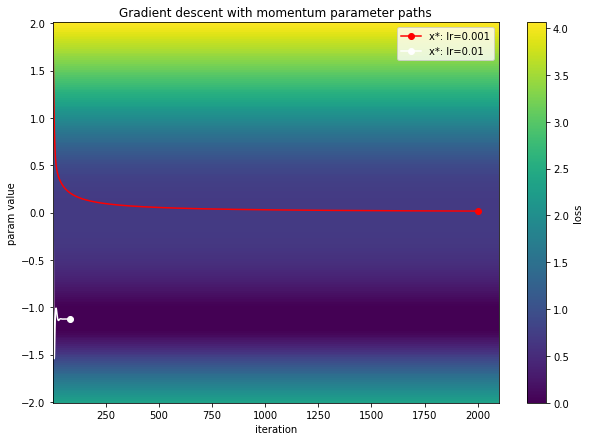

In [31]:
visualize_param_paths(
    param_paths_momentum, x_vals, loss, "Gradient descent with momentum", max_iters=2000
)

Adam Algorithm uses first moment (momentum, gradient) and second moment (RMSProp, gradient squared).
- $V_{dv} \leftarrow \overrightarrow{0}_{n \times 1}$ stores the momentum for each variable
- $S_{dv} \leftarrow \overrightarrow{0}_{n \times 1}$ stores the RMSProp for each variable
- $t \leftarrow 1$ iteration
- $\beta_1 \leftarrow 0.9$
- $\beta_2 \leftarrow 0.999$
- $\epsilon \leftarrow 10^{-1}$ prevents divisio by zero
- $r_l \leftarrow 10^{-3}$

For iteration $t$, for $i$-th variable:
- $V_{dv_i,t} = \beta_1V_{dv_i,{t-1}} + (1 - \beta_1)L'(v)_i$ momentum update
- $S_{dv_i,t} = \beta_2S_{dv_i,{t-1}} + (1 - \beta_2){L'(v)_i}^2$ RMSProp update
- $v_{dv}^{bc} = \frac{V_{dv_i,t}}{{1 - \beta_1}^t}$ momentum bias correction
- $s_{dv}^{bc} = \frac{S_{dv_i,t}}{{1 - \beta_2}^t}$ RMSProp bias correction
- $v_{i,t} = v_{i,t-1} - r_l\frac{v_{dv}^{bc}}{\sqrt{s_{dv}^{bc}} + \epsilon}$ ,
  smoothed version of sign $\frac{x}{\sqrt{x^2}}$


In [62]:
class Adam(tf.Module):
    
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, eps=1e-7):
        
        self.title = f"Adam: learning_rate={learning_rate}"
        
        self.learning_rate = learning_rate
        self.beta_1 = beta_1  # controls the size of the momentum update
        self.beta_2 = beta_2  # controls the size of the RMSProp update
        self.eps = eps  # prevents division by zero
        self.t = 1.  # iteration
        
        self.v_dvar = []  # stores the momentum updates for each variable
        self.s_dvar = []  # stores the RMSProp updates for each variable
        
        
    def apply_gradients(self, grads, vars):
        if len(self.v_dvar) == len(self.s_dvar) == 0:
            # sets up slots for the momentum/RMSProp updates on the first call
            for var in vars:
                # var.shape is () (scalar)
                # for our loss_fn, there is only one variable in vars
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
        
        # perform Adam update
        for i, (grad, var) in enumerate(zip(grads, vars)):
            # moment calculation
            self.v_dvar[i] = self.v_dvar[i] * self.beta_1 + (1 - self.beta_1) * grad
            # RMSProp calculation
            self.s_dvar[i] = self.s_dvar[i] * self.beta_2 + (1 - self.beta_2) * tf.square(grad)
            # bias correction
            v_dvar_bc = self.v_dvar[i] / (1 - (self.beta_1 ** self.t))
            s_dvar_bc = self.s_dvar[i] / (1 - (self.beta_2 ** self.t))
            # update parameter
            var.assign_sub(self.learning_rate * (v_dvar_bc / (tf.sqrt(s_dvar_bc) + self.eps)))
        self.t += 1.

In [63]:
param_paths_adam = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
    param_paths_adam[learning_rate] = convergence_test(
        optimizer=Adam(learning_rate=learning_rate),
        loss_fn=loss,
        grad_fn=grad,
        init_val=2.0,
    )

Using learning_rate=0.001. Failed to converge after 2000 iterations.
Using learning_rate=0.01. Failed to converge after 2000 iterations.
Using learning_rate=0.1. Converged at the 1156-th iteration.


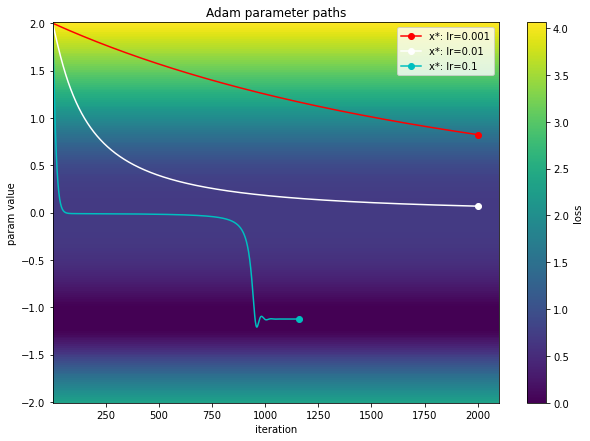

In [64]:
visualize_param_paths(
    param_paths_adam, x_vals, loss, "Adam", max_iters=2000
)